# Sidekick

Vamos a crear un proyecto completo con LangGraph que use Multi-Agents.

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver

/home/surtich/projects/IA para desarrolladores/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

### Asynchronous LangGraph

LangGraph puede funcionar en modo síncrono o asíncrono. Lo usaremos más adelante.

To run a tool:  
Sync: `tool.run(inputs)`  
Async: `await tool.arun(inputs)`

To invoke the graph:  
Sync: `graph.invoke(state)`  
Async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
from typing import Dict
import requests 

def send_email(subject: str, html_body: str, to: str, name: str = None) -> Dict[str, str]:
    """Enviar un correo electrónico"""
    from_email = os.getenv('MAILGUN_FROM')
    to_email = f"{name} <{to}>" if name else to
    content = html_body

    requests.post(
  		f"https://api.mailgun.net/v3/{os.getenv('MAILGUN_SANDBOX')}/messages",
  		auth=("api", os.getenv('MAILGUN_API_KEY')),
  		data={"from": from_email,
			"to": to_email,
  			"subject": subject,
  			"html": content})

    return {"status": "éxito"}

import os
from langchain_community.tools import StructuredTool

tool_send_email = StructuredTool.from_function(send_email, description="Útil para enviar correos electrónicos", name="send_email")




El proyecto requiere Playwright instalado. Playwright es una herramienta que permite interactuar con navegadores web de manera programática, lo cual es útil para pruebas automatizadas y scraping.

On Windows and MacOS:  
`playwright install`

On Linux:  
`playwright install --with-Deps chromium`

El código asíncrono en Python funciona como JavaScript, con el uso del `event loop`. Sólo puede haber un `event loop` en una aplicación. En este proyecto vamos a ejecutar código asíncrono dentro del `event loop`, por lo que se requieren `event loops` anidados. Para salvar la limitación de Python hacemos lo siguiente.

In [5]:
import nest_asyncio
nest_asyncio.apply()

Hay librería de LangChain que permite usar PlayWright en forma de `tools`

In [6]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

Empaquetamos las `tools` en un diccionario y probamos una de ellas:

In [7]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})

In [8]:
import textwrap
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Sign 

In [9]:
all_tools = [tool_send_email] + tools

In [10]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(all_tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

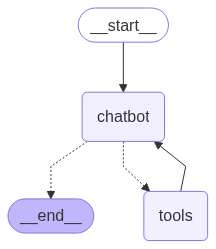

In [11]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Esto evita el error: There is no current event loop in thread 'MainThread'
import uvicorn

uvicorn.config.LOOP_SETUPS = {
    "none": None,
    "auto": "uvicorn.loops.asyncio:asyncio_setup",
    "asyncio": "uvicorn.loops.asyncio:asyncio_setup",
    "uvloop": "uvicorn.loops.uvloop:uvloop_setup",
}

In [13]:
config = {"configurable": {"thread_id": "1"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
